# Image Classification with Keras

Build a sequential model from scratch.  Features of this example:
- Batched input, suitable for large sets;
- Data augmentation; 
- Dropout and stride training.

## Input
Paths to directories containing training and validation data.  A `keras.ImageDataGenerator` is used to batch process and load these data, which must be stored according to the docs at https://keras.io/preprocessing/image/:

> **directory**: string, path to the target directory. It should contain one subdirectory per class.


## Workflow
1. Load dependencies.
2. Configure data preprocessing and augmentation.
3. Model design
4. Compile and fit.

## Notes on this Example
The dataset initially has the structure
<pre>
flowers 
 -> daisy
 -> ...
 -> tulip
</pre>
but the required structure is 
<pre>
flowers 
 -> train
     -> daisy
     -> ...
     -> tulip
 -> test
     -> daisy
     -> ...
     -> tulip
</pre>
The script that does this organising looks like 
```python
from pathlib import Path
import shutil
from numpy.random import random

p = Path('.')
(p / 'train').mkdir()
(p / 'valid').mkdir()

validation_split = 0.2

for species in 'daisy dandelion rose sunflower tulip'.split():
	(p / 'train' / species).mkdir()
	(p / 'valid' / species).mkdir()
	for img in (p / species).iterdir():
		if random() < validation_split:
			shutil.copy(str(img), str(p / 'valid' / img))
		else: 
			shutil.copy(str(img), str(p / 'train' / img))
	shutil.rmtree(p / species)
```
This can be achieved by setting the `validation_split` in the `ImageDataGenerator` constructor but anyway.

In [123]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout

import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [124]:
# Variables shared beteween training and validation flows.
prefix = './data/flowers/'
train_path = prefix + 'train'
valid_path = prefix + 'valid'
target_size = (150, 150)

def preprocess_image(image):
    """ From docs for ImageDataGenerator:
            function that will be applied on each input. 
            The function will run after the image is resized and augmented. 
            The function should take one argument: one image (Numpy tensor with rank 3), 
            and should output a Numpy tensor with the same shape.
        This example normalizes 8bit RGB."""
    return image / 255

# Data augmentation tidily handled by passing args to this constructor.
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    vertical_flip=False,
    horizontal_flip=True)

train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=target_size)
valid_generator = data_generator.flow_from_directory(
    valid_path,
    target_size=target_size)

Found 3443 images belonging to 5 classes.
Found 880 images belonging to 5 classes.


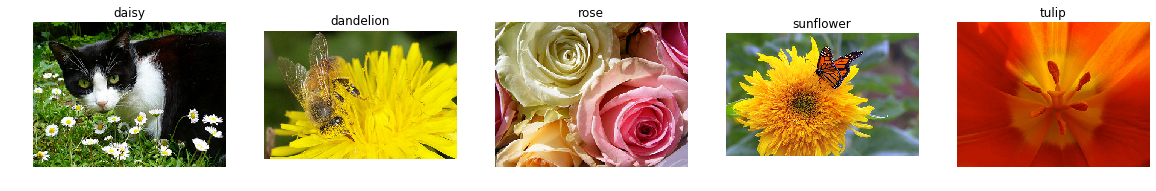

In [125]:
# Nice to see some of the data.
# Display one image from each class, with the supplied label.
images = []
labels = []
for species in [x for x in Path(train_path).iterdir() if x.is_dir()]:
    labels.append(species.name)
    species_list = list(species.iterdir())
    image_path = species_list[np.random.randint(len(species_list))]
    images.append(mpimg.imread(image_path))

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i, image in enumerate(images):
    ax[i].imshow(image)
    ax[i].set_title(labels[i])
    ax[i].axis('off')

In [126]:
model = Sequential()
num_classes = 5

# Input layer.
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',))

# Hidden layers.
for layer in [
    Conv2D(30, (3, 3), activation='relu', strides=3),
    Dropout(.5),
    Flatten(),
    Dense(128, activation='relu'),]:
    model.add(layer)

# Output layer.
model.add(Dense(units=num_classes, activation='softmax'))

In [127]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(
    train_generator,
    epochs=3,
    validation_data=valid_generator,
    )

  ...
    to  
  ['...']
Train for 108 steps, validate for 28 steps
Epoch 1/3
108/108 [==============================] - 31s 286ms/step - loss: 1.5655 - accuracy: 0.3880 - val_loss: 1.1131 - val_accuracy: 0.5295
Epoch 2/3
108/108 [==============================] - 20s 188ms/step - loss: 1.0711 - accuracy: 0.5678 - val_loss: 0.9708 - val_accuracy: 0.6193
Epoch 3/3
108/108 [==============================] - 20s 188ms/step - loss: 0.9001 - accuracy: 0.6497 - val_loss: 0.9276 - val_accuracy: 0.6375


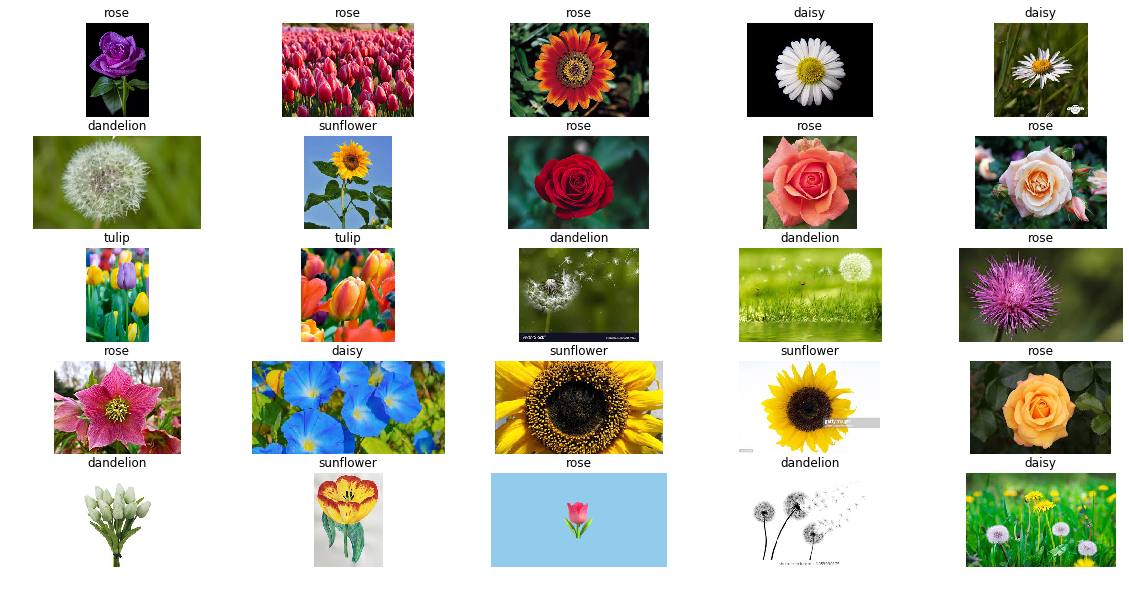

In [128]:
# Visualise some predictions. I grabbed these from google images. Some could be in the training set but I 
# would expect most to be fresh.

def predict(image_path):
    """ Make predictions one at a time."""
    image = load_img(image_path, target_size=target_size)
    y_array = model.predict(np.expand_dims(preprocess_image(img_to_array(image)), axis=0))
    return 'daisy dandelion rose sunflower tulip'.split()[y_array.argmax(axis=-1)[0]]    

image_paths = Path('./data/flowers/test').iterdir()

fig, ax = plt.subplots(5, 5, figsize=(20, 10))
for i, path in enumerate(image_paths):
    if i >= 25:
        break
    ax[i // 5, i % 5].imshow(mping.imread(path))
    ax[i // 5, i % 5].set_title(predict(path))
    ax[i // 5, i % 5].axis('off')